In [39]:
# -----------------------------------------
# ✅ IMPORTS
# -----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)

from imblearn.over_sampling import SMOTE

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


In [40]:
# -----------------------------------------
# ✅ LOAD DATA
# -----------------------------------------
df = pd.read_csv("/Users/marriamhatem/Downloads/Fraud Detection Dataset.csv")  # rename file if needed
print(df.head())
print(df.info())


  Transaction_ID  User_ID  Transaction_Amount Transaction_Type  \
0             T1     4174             1292.76   ATM Withdrawal   
1             T2     4507             1554.58   ATM Withdrawal   
2             T3     1860             2395.02   ATM Withdrawal   
3             T4     2294              100.10     Bill Payment   
4             T5     2130             1490.50      POS Payment   

   Time_of_Transaction Device_Used       Location  \
0                 16.0      Tablet  San Francisco   
1                 13.0      Mobile       New York   
2                  NaN      Mobile            NaN   
3                 15.0     Desktop        Chicago   
4                 19.0      Mobile  San Francisco   

   Previous_Fraudulent_Transactions  Account_Age  \
0                                 0          119   
1                                 4           79   
2                                 3          115   
3                                 4            3   
4                       

In [41]:
# -----------------------------------------
# ✅ DATA PREPROCESSING
# -----------------------------------------
y = df["Fraudulent"]
X = df.drop(columns=["Fraudulent"])


num_cols = X.select_dtypes(include=['int64','float64']).columns
cat_cols = X.select_dtypes(include=['object','bool']).columns

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])


In [44]:
# -----------------------------------------
# ✅ TRAIN–TEST SPLIT
# -----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Drop ID column before splitting
X = X.drop(columns=['Transaction_ID'], errors='ignore')  # errors='ignore' avoids KeyError

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# Preprocessing pipelines
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(include=['object','bool']).columns

num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

# Full pipeline with SMOTE
model = ImbPipeline([
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42))
])

# Fit model
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.951921568627451


In [51]:
# Full pipeline with preprocessing + SMOTE + RandomForest
model = ImbPipeline([
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced",
        random_state=42
    ))
])

# Fit directly on original X_train, y_train
model.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [52]:
# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

# Metrics
print("Accuracy :", round(accuracy_score(y_test, y_pred), 4))
print("Precision:", round(precision_score(y_test, y_pred), 4))
print("Recall   :", round(recall_score(y_test, y_pred), 4))
print("F1 Score :", round(f1_score(y_test, y_pred), 4))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_prob), 4))


Accuracy : 0.952
Precision: 0.8
Recall   : 0.0319
F1 Score : 0.0613
ROC-AUC  : 0.5382


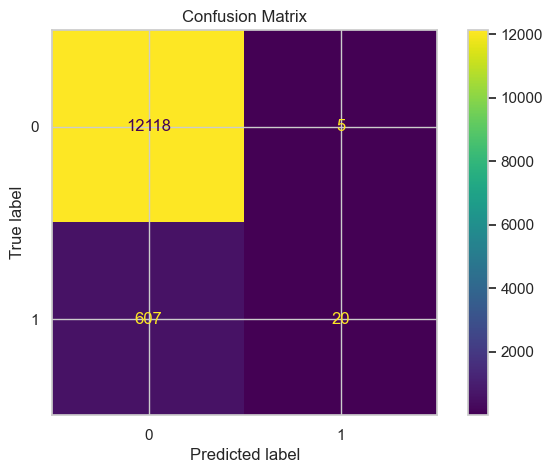

In [53]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()


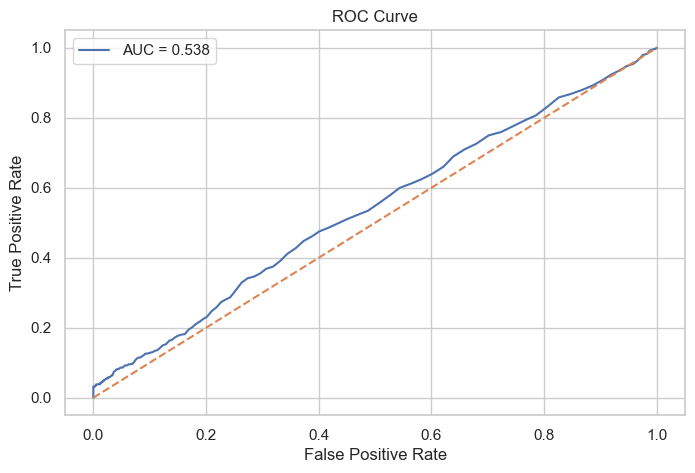

In [54]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


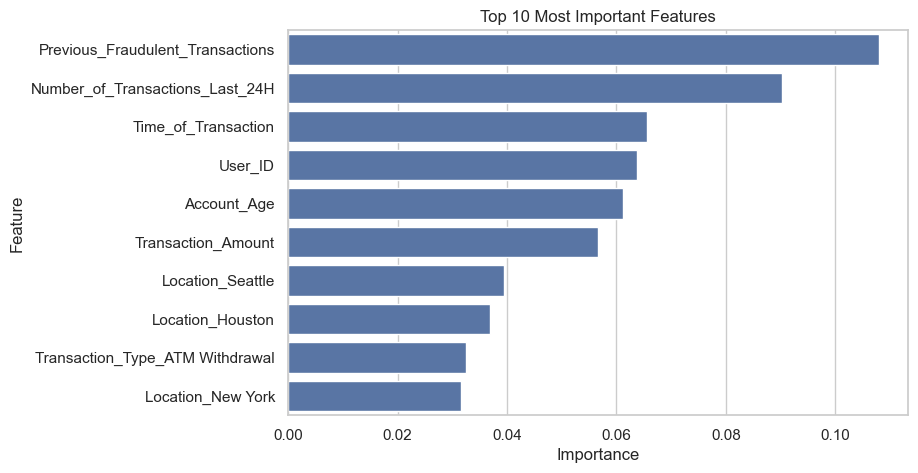

In [55]:
rf_model = model.named_steps["rf"]
feature_names = list(
    model.named_steps['preprocess']
    .named_transformers_['num']
    .named_steps['imputer']
    .feature_names_in_
) + list(model.named_steps['preprocess']
        .named_transformers_['cat']
        .named_steps['encoder']
        .get_feature_names_out(cat_cols)
)

importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False).head(10)

sns.barplot(x="Importance", y="Feature", data=feat_imp)
plt.title("Top 10 Most Important Features")
plt.show()
